In [3]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier

In [ ]:
# BROADCASTING = a technique to use arrays & tensors expressively
    # basically "pads" a lesser-ranked tensor to match another tensor it needs to do math with
# SGD = Stochastic Gradient Descent, the mechnaism for learning by updating weights automatically :-D


## Pixels: The Foundations of Computer Vision

## Sidebar: Tenacity and Deep Learning

## End sidebar

In [23]:
# MNIST is a dataset in computer vision, it contains images of handwriten digits.
# Here we're making a model that can tell if a digit is a 3 OR 7
    # the 3 & 7 images are in MNIST_SAMPLE

path = untar_data(URLs.MNIST_SAMPLE)

In [24]:
#hide
Path.BASE_PATH = path
print(path)
print(type(path))

# can also do stuff like...
# path.ls??  # for source code
doc(path)    # for docs


/home/jupyter/.fastai/data/mnist_sample
<class 'pathlib.PosixPath'>


fastai/data/mnist_sample [source] Path subclass for non-Windows systems. 
 On a POSIX system, instantiating a Path should return this object.

In [25]:
# see there are 3 folders under this path
path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

In [28]:
# and 2 folders under train/
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [29]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [30]:
# Use Image class from PIL/PythonImagingLibrary to show a file under a path

im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [31]:
# To see the numbers that make up this image,
# ... we need to convert it to a NumPy array
# array(openedImage)[rowRange, colRange], where range format is inc:exc
    # the example below gives rows from index4 to index9, and columns from 4-9.  
    # With row/column 0/0 being the top left hand corner.

array(im3)[4:10,4:10]
    # dtype says they're 8bit unsigned int

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [10]:
# ... Or convert it to a PyTorch tensor
    # basically a Pytorch version of a NumPy array, behaviors almost identically
    # !!! the diff is PyTorch tensor can be computed on GPU, and has more functionalities
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [10]:
# change them back to color... 0=white, 255=black
# using a Panda DataFrame

im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:10,4:10])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5
0,0,0,0,0,0,0
1,0,0,0,0,0,29
2,0,0,0,48,166,224
3,0,93,244,249,253,187
4,0,107,253,253,230,48
5,0,3,20,20,15,0


In [11]:

im3_tBigger = tensor(im3)
dfBigger = pd.DataFrame(im3_tBigger[4:15,4:22])
dfBigger.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## First Try: Pixel Similarity

In [ ]:
So, here is a first idea: 
    how about we find the average pixel value for every pixel of the 3s, 
    then do the same for the 7s. 
This will give us two group averages, defining what we might call the "ideal" 3 and 7. 
Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to. 
This certainly seems like it should be better than nothing, so it will make a good baseline.

Baseline === A simple model which you are confident should perform reasonably well. 
    It should be very simple to implement, 
    and very easy to test, so that you can then test each of your improved ideas, 
    and make sure they are always better than your baseline. 
Without starting with a sensible baseline, it is very difficult to know whether your super-fancy models are actually any good. 

One good approach to creating a baseline is doing what we have done here: 
    think of a simple, easy-to-implement model. 
Another good approach is to find other people that have solved similar problems to yours, 
    and download and run their code on your dataset. 

Ideally, try both of these!

In [32]:
# tensor(imageObj) to translate into tensors!
seven_tensors = [tensor(Image.open(img)) for img in sevens]
three_tensors = [tensor(Image.open(img)) for img in threes]
print(f"{len(three_tensors)} images of 3 are now tensors,\n{len(seven_tensors)} images of 7 are now tensors")
print("check out one right now!")
three_tensors[1]

6131 images of 3 are now tensors,
6265 images of 7 are now tensors
check out one right now!


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29, 150, 195, 254, 255, 254, 176, 193, 150,  96,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,  48, 166, 224, 253, 253, 234, 196, 253, 253, 253, 253, 2

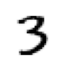

In [26]:
# show_image(tensorObj) to translate back into image!

show_image(three_tensors[1]);

In [34]:
# Now we want to stack all these numbers on top of each other, and later we'll average it
    # ok... that's why we want tensors to have the same size

# Here we're STACKING allt he imgs into a single 3D tensor, aka "rank-3 tensor"    
    # Since we'll be doing math on it later, let's cast it to float()
    # we want float pixel values to be between 0 and 1, so we need to divide the color by 255
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

# the SHAPE tells u the length of each axis, 
    # this tells us we have 6131 images, each of size 28x28pixels
stacked_threes.shape

torch.Size([6131, 28, 28])

In [14]:
# the RANK is the length of a tensor's SHAPE.   
    # remember earlier, we're stacking all our images into a 3D tensor, aka rank-3 tensor
print(f"RANK = {len(stacked_threes.shape)}  \t<-- via len(tensorObj.shape)")
print(f"RANK = {stacked_threes.ndim}  \t<-- via tensorObj.ndim")

RANK = 3  	<-- via len(tensorObj.shape)
RANK = 3  	<-- via tensorObj.ndim


In [ ]:
!!! DIMENSION is sometimes used in 2 ways
    size of an AXIS
    size of a RANK (or, number of AXES)
Best to just use Rank & Axis & Length instead of DIMENSION

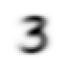

In [35]:
# Let's look at the IDEAL 3!
mean3 = stacked_threes.mean(0)
show_image(mean3);

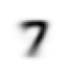

In [16]:
# Look at the IDEAL 7!
mean7 = stacked_sevens.mean(0)
show_image(mean7);

In [ ]:
!!! waaaait... but if someone rotates a test data, then this would not work...

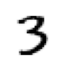

In [36]:
### Now we want to see how one of our training piece measures up against this AVERAGE/IDEAL 3   
    # we want to measure its DISTANCE from our ideal

# take a random 3
a_3 = stacked_threes[1]
show_image(a_3);

In [18]:
# print(a_3)  <- will print a giant tensor of numberes
# print()
# print(mean3)


dist_3_abs = (a_3 - mean3).abs().mean()
    # using abs() to so +/-'s don't wash each other out
    # MEAN ABSOLUTE DIFFERENCE, aka L1 NORM
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
    # ROOT MEAN SQUARED ERROR (RMSE), aka L2 NORM
    
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [19]:
# ok, how does our random 3 measure against the ideal/mean 7?
    # yesssss... this one is farther away, so we're more sure our random 3 is a 3 than we are it's a 7

dist_7_abs = (a_3 - mean7).abs().mean()
    # MEAN ABSOLUTE DIFFERENCE, aka L1 NORM
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
    # ROOT MEAN SQUARED ERROR (RMSE), aka L2 NORM
    
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [20]:
# LOSS FUNCTIONS
    # via torch.nn.functional, which is commonly imported as F
    
# rewriting the dist_3_abs & dist_3_sqr above...
print(F.l1_loss(a_3.float(), mean3))
print(F.mse_loss(a_3, mean3).sqrt())

# rewriting the dist_7_abs & dist_7_sqr above...
print(F.l1_loss(a_3.float(),mean7))
print(F.mse_loss(a_3,mean7).sqrt())

tensor(0.1114)
tensor(0.2021)
tensor(0.1586)
tensor(0.3021)


In [ ]:
MEAN ABSOLUTE DIFFERENCE (L1 NORM) vs ROOT MEAN SQUARED ERROR (RMSE)(L2 NORM)
    L2 NORM is supposed to penalize bigger mistakes more heavily,
    but more lenient with small mistakes

L1_NORM = (tensor1 - tensor2).abs().mean()
L2_NORM = [(tensor1 - tensor2)**2].mean().sqrt()

### NumPy Arrays and PyTorch Tensors

In [ ]:
# WHY NumPy arrays or PyTorch tensors? 
#     computes way faster bc they're in C

# PyTorch tensors cannot be jagged, it's always a regular shaped multidimensional rect structure.
# PyTorch tensors also can't use just any type, it has to be a single basic numeric type for all comps.

    

In [45]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [46]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [47]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [48]:
tns[1]

tensor([4, 5, 6])

In [49]:
tns[:,1]

tensor([2, 5])

In [50]:
tns[1,1:3]

tensor([5, 6])

In [51]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [52]:
tns.type()

'torch.LongTensor'

In [53]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## Computing Metrics Using Broadcasting

In [ ]:
L1_NORM & L2_NORM above are great and all, but not very understandable.
    ^ These loss fcns describe how well the model works with our TRAINING SET
So we normally use ACCURACY as the metric for classification models.

This metric is calc'd over a VALIDATION SET.

So now we'll grab the validation set from the valid/ folder

In [21]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255


# check shapes as u go.  Here we see we have a 3-rank tensor, with 3 axes of 1000+ images, 28 pixels x 28 pixels
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [22]:
# calc the mean absolute error thusly:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
    # what is this (-1, -2) in mean above???
        # it's a range of axes. Last & 2nd-to-last element, basically the pixels.
        # we averaged the intensity of all the pixels in an image.
    # this is meant to be somewhat similar to how we wrote L1_NORM above
mnist_distance(a_3, mean3)

tensor(0.1114)

In [23]:
# To calc a metric for overall ACCURACY, we need the distance to ideal 3 for EVERY image in the VALIDATION SET
# but we don't need to loop it, just pass in the entire tensor set
    # huh... it actually didn't throw an error
    # PyTorch magic in (a-b),
        # When it tries to subtract between 2 tensors of diff RANKS, will use BROADCASTING!!!
        # It AUTO EXPANDS the tensor w/ the samller rank to the same size as the one with the larger rank!!!
        # So this BROADCASTING happens to mean3 when it's up against valid_3_tens!!!
            # Basically, it's like there's 1000+ ideal images to subtract against each tensor in valid_3_tens!!!
        
print("single tensor a_3 vs full set valid_3_tens")
print(f"\tRANK = {len(a_3.shape)} <-- tensor of single image with 28x28 pixels")
print(f"\tRANK = {len(valid_3_tens.shape)} <-- 3D (rank3) tensor with 1000+imgs of 28x28 pixels")
print(f"\tRANK of mean3 = {len(mean3.shape)} <-- tensor of single IDEAL image with 28x28 pixels")

valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

single tensor a_3 vs full set valid_3_tens
	RANK = 2 <-- tensor of single image with 28x28 pixels
	RANK = 3 <-- 3D (rank3) tensor with 1000+imgs of 28x28 pixels
	RANK of mean3 = 2 <-- tensor of single IDEAL image with 28x28 pixels


(tensor([0.1202, 0.1417, 0.1763,  ..., 0.1292, 0.1318, 0.1603]),
 torch.Size([1010]))

In [24]:
# oh snap!  BROADCASTING turns the 2nd element into [1,1,1]
tensor([1,2,3]) + tensor(1)


tensor([2, 3, 4])

In [25]:
print(valid_3_tens.shape)
print(mean3.shape)

# We are calculating the difference between our "ideal 3" and each of the 1000+  in the validation set, 
    # for each of 28×28 images, resulting in the shape [1010,28,28].
(valid_3_tens-mean3).shape

### PyTorch doesn't ACTUALLY copy mean3 1000x, it just pretends it were a tensor of that shape.
# It does the whole calc in C (or in CUDA if you're using a GPU), which up to 1Mx faster.

torch.Size([1010, 28, 28])
torch.Size([28, 28])


torch.Size([1010, 28, 28])

In [26]:
### THIS IS THE PREDICTION!!!! X is 3 if it's closer to mean3 than it is to mean7
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [23]:
# Prediction just a_3 taken from our training set
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [27]:
# Prediction on the entire validation set
is_3(valid_3_tens)

tensor([ True,  True,  True,  ...,  True,  True, False])

In [28]:
# Now we can calculate the accuracy for each of the 3s and 7s 
# by taking the average of that function for all 3s and its inverse for all 7s:

accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD)

In [ ]:
Now use GSD to auto figure out the best weights for our model!
... but HOW?!

Instead of trying to find the similarity between an image and an "ideal image," 
we could instead look at each individual pixel 
and come up with a set of weights for each one, 
such that the highest weights are associated with those pixels most likely to be black for a particular category

For instance, pixels toward the bottom right 
    are not very likely to be activated for a 7, so they should have a low weight for a 7, 
    but they are likely to be activated for an 8, so they should have a high weight for an 8. 
    
    
########## STEPS: ##########
    1. Initialize the weights
            usu random
    2. For each img, use these weights to PREDICT whether it's a 3 or 7
    3. Based on these predictions, calc LOSS (how good the model is)
            loss fcn returns small number if model is good, large number if bad
    4. Calc he GRADIENT, which measures for each weight, how changing that weight can change loss
    5. STEP (change) all the weights based on that calc
            incr or decr a bit, in the direction of low loss.
            can be slow if we do baby steps, but with GRADIENT calc we can take bigger steps.
    6. Go back to step 2, repeat.
    7. Iter til u stop the training process (once it's good enough or used up all epochs)

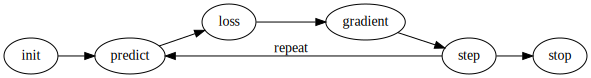

In [73]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [74]:
def f(x): return x**2

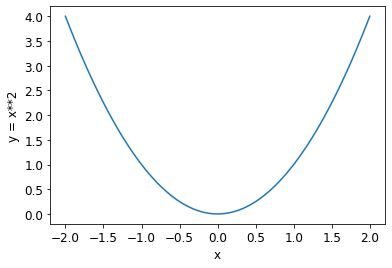

In [76]:
plot_function(f, 'x', 'y = x**2')

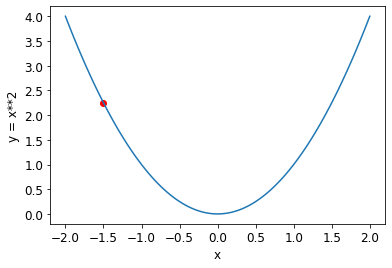

In [77]:
plot_function(f, 'x', 'y = x**2')
plt.scatter(-1.5, f(-1.5), color='red');

In [ ]:
If we +/- our param by a bit (the ADJUSTMENT), this is the slope at a particular point.
We can get to the lowest point of the curve by chg the x/weight, and see what y/result we get.
Based on the slope (loss), adjust how much to change x/weight next time.
Do this until we eventually get to the lowest point on the curve
    [0,0] where the slope=0 loss is minimum, yay

The further away from [0,0] we are, the steeper the slope, so the more we need to change x/weight
    Starting at the randomized red dot where the init weight is -1.5
    I guess this is what happesn....
        We want a flatter slope, so pretend we decr x to -2.5
        That gives us a worse/steeper slope/loss, so we incr x instead, to -0.5
        That gives us a nice flater slope, can we do better?
        Try incr to 0.5
        Slope is same, but diff direction, so double back to x=0
        yay, foudn it.
    But... how do we know how much to adjust? See "STEPPING WITH LEARNING RATE" below
    
Calculus derivatives tells us how fast the slope changes: 
    slope = (y2-y1)/(x2-x1)
    
Our actual fcn has LOTS Of adjustable weights, 
    so we will get back LOTS of derivatives, 1 for each weight.


### Calculating Gradients

In [81]:
# PyTorch will calc derivs for us, yay
    # .requires_grad() says we want to calc gradients wrt that weight variable at that value.

xt = tensor(3.).requires_grad_()

In [82]:
# Now we calculate our function with that value. 
    # Notice how PyTorch prints not just the value calculated, 
    # but also a note that it has a gradient function it'll be using to calculate our gradients when needed
yt = f(xt)
    # remember earlier we defined f(arg1) to return arg1**2
    # so here we are telling it to pass in tensor(3) to be squared
yt

tensor(9., grad_fn=<PowBackward0>)

In [83]:
# functionValue.backward() tells it to CALC GRADIENTS for us
    # BACKPROPAGATION, name given to the process of calc deriv of each layer
    # aka "backward pass" of the network, vs "forward pass" where the activations are calc'd
    # ^ what?!

yt.backward()

In [84]:
# paramTensor.grad to view gradients
    # y = x^2 has derivative of 2x, therefore since we passed in tensor(3), we get deriv of tensor(6)
xt.grad

tensor(6.)

In [85]:
# now try a bigger tensor as the x/weight/params

xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [86]:
# with a diff fcn

def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [87]:
# valueFromFcn.backward() to CALC GRADIENT/derivative        # slope is still 2x
# params.grad to show it
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

### Stepping With a Learning Rate

In [ ]:
Basically multiply the gradient by some small number called LEARNING RATE (LR)
    LR is usu between 0.001 and 0.1
    Ppl try a few diff LRs to see which gives the best model (also covered in LEARNING RATE FINDER later)

LRs that are too low are baby steps, and training can take forever
LRs that are too high is worse, causes doubling back on directions due to overshoot.
See pictures in non-clean version, but its' pretty dang obvious from the parabola graph above in cell 78.
    

### An End-to-End SGD Example

In [139]:
# pretend these are the speeds measured of a roller coaster q20sec
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

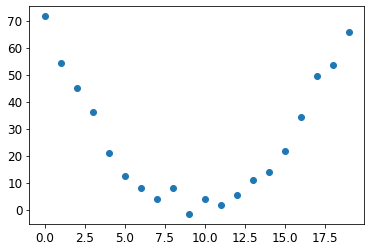

In [140]:
# ignore this line below, it's just generating ~random graph points
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [141]:
# f() is our PREDICTION, for describing what the real blue speed data we see above
# a/b/c are params that corresp to what kind of quadratic shape we're trying.  
    # a for quadratic, b for linear, c for constant
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [142]:
# we need to define first what we mean by "best"
### so we use a LOSS FCN here.  
    # lower = better
    # SGD will adjust weights towards lower LOSS FCN values, to minimize loss.
    # For continuous data, it's common to use MEAN SQUARED ERROR

def mse(preds, targets): return ((preds-targets)**2).mean().sqrt()

#### Step 1: Initialize the parameters

In [143]:
# remmeber to take on .requires_grad() to tag it for GRADIENT calc!
params = torch.randn(3).requires_grad_()
print(f"Our first randomized params {params}")

Our first randomized params tensor([ 0.4000, -1.2039, -0.4198], requires_grad=True)


In [144]:
#hide
orig_params = params.clone()

#### Step 2: Calculate the predictions

In [145]:
# Run our params through our prediction model f()
preds = f(time, params)

In [146]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

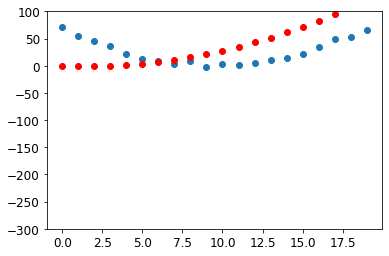

In [147]:
# red plot is my initial "prediction" using the randomized a/b/c params
# blue plot is the real-life speed data that I'm trying to approx w/ my model
show_preds(preds)

#### Step 3: Calculate the loss

In [148]:
# Look at the MSE of red-v-blue delta-Y for each x
loss = mse(preds, speed)
print(f"INITIAL TRIAL: loss = {loss}")

INITIAL TRIAL: loss = 40.331939697265625


#### Step 4: Calculate the gradients

In [149]:
### lossVal.backward() <-- TO CALC GRADIENT/deriv
### params.grad        <-- to GIVE results
loss.backward()
print("What is the slope/derivative? We want close to 0")
params.grad


What is the slope/derivative? We want close to 0


tensor([128.1733,   8.0188,   0.2868])

In [152]:
# FOR Step 5, we can ADJUST the weight! via LEARNING RATE
chgToNewParams = params.grad * 1e-5
chgToNewParams

tensor([1.2817e-03, 8.0188e-05, 2.8682e-06])

In [151]:
# we haven't actually changed the params yet
params

tensor([ 0.4000, -1.2039, -0.4198], requires_grad=True)

#### Step 5: Step the weights. 

In [156]:
# update the parameters based on the calc'd gradient
lr = 1e-5

# NOTE that we're decreasing params.DATA, not params itself
params.data -= lr * params.grad.data

# ALSO, now that params is updated ot new value, we need to wipe the gradient results in params.grad
params.grad = None

In [157]:
# what's the new prediction & resulting loss value?
preds = f(time,params)
loss = mse(preds, speed)
print(f"loss = {loss}  <-- is it lower this time?")

print("How does params.grad look? is the tensor a lower derivative now?")
loss.backward()
params.grad


# To calculate the gradients...
# we call backward on the loss value. 
  # But this loss was itself calculated by loss fcn of mse(), 
    # which took preds as an input, 
      # which was calc'd using starter prediction of f(), taking as an input params, 
        # which was the object on which we originally called .required_grads_ on, to track these weight/params
          # which is the original call that now allows us to call backward on loss value

loss = 39.84030532836914  <-- is it lower this time?
How does params.grad look? is the tensor a lower derivative now?


tensor([127.0341,   7.9431,   0.2784])

In [ ]:
##### The loss & params.grad should be lower this time, since we're making baby steps (0.00001)
# towards a lower slope.  
# Unless we went the wrong direction, idk how we decided on DECR instead of INCR

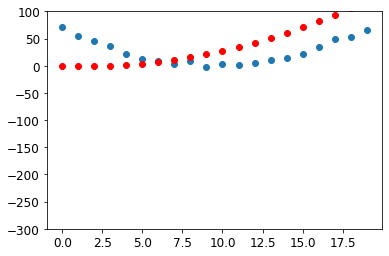

In [158]:
show_preds(preds)

In [165]:
# Since we need to repeat STEP 5 a bunch of times, we need this:
        # I added the 2nd param so I can adjust it myself
def apply_step(params, lr=1e-5, prn=True):
    # Make prediction w/ given params
    preds = f(time, params)
    # Calc loss fcn value from prediction
    loss = mse(preds, speed)
    # Calc GRADIENT on that loss fcn value
    loss.backward()
    # We could show params.grad and see how our slope/deriv is hopefully flatter now, but not gonna bother
    # Adjust per Learning Rate
    params.data -= lr * params.grad.data
    # Wipe params.grad for next gradient calc
    params.grad = None
    if prn: 
        print(loss.item())
        # show_preds(preds)  # graphs might not look all that diff from each other bc LR is so small
    return preds

#### Step 6: Repeat the process 

In [166]:
# see the loss is going down :-D
# THIS IS 10 EPOCHS
for i in range(10): apply_step(params)

38.72935104370117
38.574607849121094
38.420894622802734
38.268211364746094
38.1165657043457
37.965965270996094
37.816410064697266
37.667903900146484
37.52045822143555
37.37407684326172


In [167]:
#hide
params = orig_params.detach().requires_grad_()

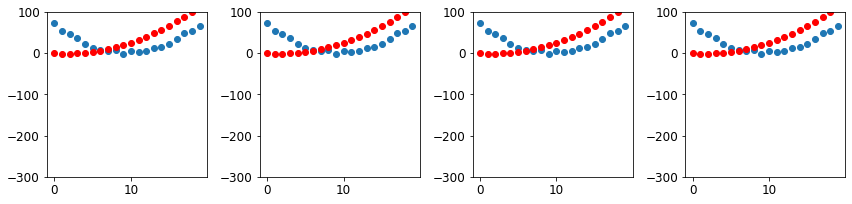

In [168]:
# ok, the loss is going down, let's also look at how prediction graphs changed through time
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

In [180]:
# What if I'm not happy yet and want 50 epochs??? with a more aggressive LR???

for i in range(50): apply_step(params, lr*1000)

26.02480125427246
26.0246524810791
26.024503707885742
26.02436065673828
26.024221420288086
26.02408218383789
26.023950576782227
26.023815155029297
26.023685455322266
26.023561477661133
26.023435592651367
26.0233154296875
26.023197174072266
26.023082733154297
26.022966384887695
26.022855758666992
26.022747039794922
26.022640228271484
26.02253532409668
26.02243423461914
26.02233123779297
26.022235870361328
26.022140502929688
26.02204704284668
26.021953582763672
26.02186393737793
26.021778106689453
26.021690368652344
26.021604537963867
26.021522521972656
26.021442413330078
26.021360397338867
26.021286010742188
26.021209716796875
26.021135330200195
26.021060943603516
26.0209903717041
26.020919799804688
26.020851135253906
26.020784378051758
26.020719528198242
26.02065658569336
26.020591735839844
26.020530700683594
26.020469665527344
26.020410537719727
26.02035140991211
26.020296096801758
26.020238876342773
26.020187377929688


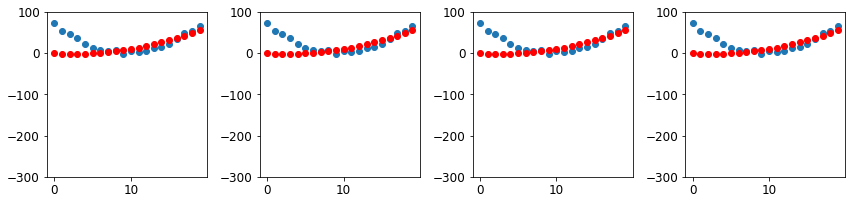

In [181]:
# Have I gotten even closer?!
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

### Summarizing Gradient Descent

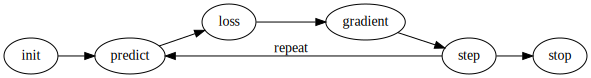

In [182]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

## The MNIST Loss Function

In [ ]:
# We concatenate all our independent variables x/images into 1 single tensor
# and change them from a list of matrices (a Rank-3 tensor) to a list of vectors (a Rank-2).
#     Do this via .VIEW()
#     which changes the shape fo a tensor w/o changing its contents
#    .view() args tell it how large u want the dimensions to be
#     param -1 means "make this axis as big as necessary to fit all the data"


In [29]:
# OK don't really understand this torch.cat() thing... 
  # I guess we just line up all the images of 3s followed by all the images of 7s

train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape

# Here we reshaped it into a matrix where each row is 1 image w/ all the rows & cols of image as a single vector
# we have 12396 images total


torch.Size([12396, 784])

In [41]:
# Need y labels for each image x.  
# Use '1' for Threes and '0' for Sevens
    # bc our model is "is_3"

train_y_just_labels = tensor([1]*len(threes) + [0]*len(sevens))
print(train_y_just_labels)
print(train_y_just_labels.shape)

train_y = train_y_just_labels.unsqueeze(1)
    # train_y_just_labels here is a vector,
      # but we want a matrix of same shape as train_x so we pad it out w/ another column
    # wassup w/ .unsqueeze()?
    # without unsqueeze we'll get train_y.shape = torch.size([12396])
    # if unsqueeze(0) then we get torch.Size([1, 12396])
    # if unsqueeze(-1) then we get torch.Size([12396, 1])
    # so I guess.... unsqueeze(indexWhereYouWantPadded)?

print(f"what is train_y[0]? {train_y[0]} \n\t<-- label of first image in train_x, which is a 3, therefore true/1")
print(f"what is train_y[-1]? {train_y[-1]} \n\t<-- label of last image in train_x, which is a 7, therefore false/0")
    
train_y.shape
# we have 12396 labels total, and an extra column in train_y matrix so train_x and train_y match shapes


# now these train_x & train_y are Rank2 tensors

tensor([1, 1, 1,  ..., 0, 0, 0])
torch.Size([12396])
what is train_y[0]? tensor([1]) 
	<-- label of first image in train_x, which is a 3, therefore true/1
what is train_y[-1]? tensor([0]) 
	<-- label of last image in train_x, which is a 7, therefore false/0


torch.Size([12396, 1])

In [ ]:
# OK... so I'm guessing...
#     train_x is all the x/images 
#     train_y is all the y/real labels 
#     And together each x correspond to each y, and that's what's going on w/ this zip, it pairs them up
#     now we got all these (x,y) points
#     we plot this xy graph
# OUR MODEL needs to have the correct weights to correctly describe this xy graph,
#     so that when we test it with some other new x, it can return the predicted y
#         and if y close to 1 then we know we're looking at a Three
#         if y close to 0 then we're looking at a Seven

In [43]:
# a DATASET in PyTorch is req'd to return a tuple of (x,y) when indexed
    # ok idk what's up with x.shape = 28*28 = 784, 
        # guess it's the white/black saturation level at each pixel
    # y.shape is [1] bc it's just the label 0/F or 1/T for whether that image is a Three

dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y.shape,y

(torch.Size([784]), torch.Size([1]), tensor([1]))

In [38]:
# just trying ot visualize what's going on
x = [tensor(1),tensor(2),tensor(3)]
y = [tensor(7),tensor(8),tensor(9)]
fake_dataset = list(zip(x,y))
x,y = fake_dataset[0]
print(fake_dataset[0])
print(f"x = {x}\ny = {y}")
print(x.shape, y.shape)
print()
x = [tensor([1]),tensor([2]),tensor([3])]
y = [tensor([7]),tensor([8]),tensor([9])]
fake_dataset = list(zip(x,y))
x,y = fake_dataset[0]
print(fake_dataset[0])
print(f"x = {x}\ny = {y}")
print(x.shape, y.shape)
print()
xx = [tensor([1,11]),tensor([2,22]),tensor([3,33])]
yy = [tensor([7,77]),tensor([8,88]),tensor([9,99])]
fake_dataset = list(zip(xx,yy))
xx,yy = fake_dataset[0]
print(fake_dataset[0])
print(f"xx = {xx}\nyy = {yy}")
xx.shape, yy.shape


(tensor(1), tensor(7))
x = 1
y = 7
torch.Size([]) torch.Size([])

(tensor([1]), tensor([7]))
x = tensor([1])
y = tensor([7])
torch.Size([1]) torch.Size([1])

(tensor([ 1, 11]), tensor([ 7, 77]))
xx = tensor([ 1, 11])
yy = tensor([ 7, 77])


(torch.Size([2]), torch.Size([2]))

In [45]:
# make a DATASET for the validation set too
    # after we train the model and get the weights we like,
    # run each of these validation dataset values thru the model
    # and see if the predictions match the answer key
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [ ]:
    ########## STEPS: ##########
    1. Initialize the weights
            usu random
    2. For each img, use these weights to PREDICT whether it's a 3 or 7
    3. Based on these predictions, calc LOSS (how good the model is)
            loss fcn returns small number if model is good, large number if bad
    4. Calc he GRADIENT, which measures for each weight, how changing that weight can change loss
    5. STEP (change) all the weights based on that calc
            incr or decr a bit, in the direction of low loss.
            can be slow if we do baby steps, but with GRADIENT calc we can take bigger steps.
    6. Go back to step 2, repeat.
    7. Iter til u stop the training process (once it's good enough or used up all epochs)

In [46]:
### STEP 1 ### initialize random weights
    # IDU wassup w/ the std here, i guess the size is how many diff pixels that's in each x/image
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

# requires_grad_() <-- the underscore at the end changes the tensor it's attached to

In [58]:
weights = init_params((28*28,1))
weights.shape

torch.Size([784, 1])

In [53]:
# IDU... but apparently...
# The function weights*pixels won't be flexible enough—it is always equal to 0 when the pixels are equal to 0 (i.e., its intercept is 0).
# so initiialize it to a random number too

bias = init_params(1)
bias


tensor([0.9214], requires_grad=True)

In [56]:
# y = w(x) + b
    # w = weights
    # b = y-intercept, aka BIAS
    # x = image, independent variable
    # y = prediction, dependent variable
    # together, the weights w & bias b make up the PARAMETERS

# So the prediction for 1 image is...
(train_x[0]*weights.T).sum() + bias

tensor([-15.0444], grad_fn=<AddBackward0>)

In [85]:
# REMEMBER that we do NOT want to run python loops bc slow!
# w*x for every row is done via MATRIX MULTIPLICATION <-- which is @ in python
    # vaguely remember from undergrad, not gonna bother 
    # https://www.youtube.com/watch?v=kT4Mp9EdVqs

In [59]:
### SUPER IMPORTANT EQUATION ... batch@weights + bias ###
    # the other one is the activation fcn, cov'd later

def linear1(xb): return xb@weights + bias
    # guess fcn is named this bc y=mx+b is linear
    # but without plotting out the xy graph, how would we know if it isn't quadratic or somethign more?

# Run our training dataset (train_x) thru this prediction model (linear1), using our curr initial weights
preds = linear1(train_x)
preds

tensor([[ 2.5882],
        [-2.1473],
        [ 1.8853],
        ...,
        [-4.5317],
        [ 1.4997],
        [ 4.5954]], grad_fn=<AddBackward0>)

In [60]:
# Let's check our ACCURACY. 
    # To decide if an output represents a 3 or a 7,
    # we define 0 as the cutoff, if >0 then we're looking at a 3, 
    # so our accuracy for each item can be calculated (using broadcasting, so no loops!) 
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [False],
        [ True],
        ...,
        [ True],
        [False],
        [False]])

In [64]:
# turn those T/F into 1/0s via float() and average it
as_a_tensor = corrects.float().mean()
as_a_scalar = corrects.float().mean().item()
print(as_a_tensor)
print(as_a_scalar)

# since the linear1() predictive model ran with the weights being the initialized random numbers,
# we can't expect the accuracy to be all that great.
# But with each iteration/epoch where we change the weights towards a lower loss, 
# we should see this accuracy increase!

tensor(0.6317)
0.6317360401153564


In [62]:
# ok i have no idea why we decided on a positive change instead of neg
    # thought we're supposed to try both ways...

### I DIDN'T DO NOTHING!!!! WHYYYYYYY!!!!
# UGH!!! RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.
weights[0] *= 1.0001

RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.

In [68]:
# PRETEND that we successfully changed weights[0]
# we run the training dataset thru the prediction model again, this time the weights changed
# get new predictions
preds = linear1(train_x)

# Are these new predictions any better? 
    # bc the prev cell had RuntimeError, we'll get the same results bc we couldn't chg the weights
    # u know what? if this is a continuous equation that we're trying to approx, then we should see an improvement
    # BUT since this is a discrete bucket/categorization thing, y label is either 1 or 0.
        # So any little changes in x is unlikely to change y
        # So y_new - y_old is almost always 0 in this case
        # and since slope = (deltaY)/(deltaX) = 0... gradient is 0 almost everywhere
        # so even if we did successfully change the weights[0] by 0.1% above, we'll prob gett he same preds here anyway
((preds>0.0).float() == train_y).float().mean().item()

# ACCURACY is a fcn that is constant almost everywhere (except at the threshold), 
# so its derivative is nil almost everywhere (and infinity at threshold)
# This then gives gradients that are 0 or infinite, whih are USELESS for updating the model


0.6317360401153564

In [ ]:
# Since ACCURACY is not practical here, we need a better loss fcn,
# where tweaks in weights will result in different predictions.

# NOW let's write a better loss fcn
# the loss fcn reeives predictions from th emodel
# let's say we have "prds" below, a Rank-1 tensor, of predictions on the 3-ness of some imgs
# loss fcn meases the diff between the predicted values vs true/label/answerKey/target values
# let's say "trgts" is that answer key, where it tells us the imgs are true,false,true on their 3-ness
# the loss fcn will compare prds against trgts

In [73]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [74]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

# torch.where(a,b,c)
# this is the same as running... [b[i] if a[i] else c[i] for i in range(len(a))]
# basically... for each element in targets, if a is true do b else do c

# NOTE, mnist_loss as defined assumes the predcitions is always between 0 and 1
# so need to make sure that this is true! (spoiler alert: sigmoid fcn below)

In [77]:
# these are the resulting tensors based on the torch.where condition
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [76]:
# this is the loss for prds when compared to trgts
mnist_loss(prds,trgts)

tensor(0.4333)

In [79]:
# now try a better set of prds, where the 3rd pred is much closer, we get a lower loss :-D
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

### Sigmoid

In [80]:
# Sigmoid always outputs a number between 0 and 1

def sigmoid(x): return 1/(1+torch.exp(-x))

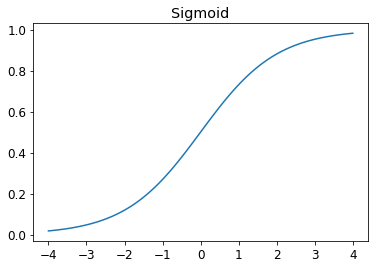

In [81]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)


In [83]:
def mnist_loss(predictions, targets):
    # this below forces the predictions beween 0 and 1 so it plays nice with torch.where(a,b,c)
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [ ]:
# metric is for human understanding
# loss is to drive automated learning
#     For that to work, the loss must be a fcn w/ a meaningful deriv
#     it can't have big flat sections and large jumps,
        # this is what happened when we looked at ACCURACY earlier of just true/false preds
#     but instead must be reasonably smooth
    
# the loss fcn is calc'd for each item in our dataset
# then at the end of an epoch, the loss values are all averaged and reported

# Metrics are what we really care about, so focus on these instead of loss when judging the perf of a model

### SGD and Mini-Batches

In [ ]:
# OPTIMIZATION STEP
# now we want to tweak the weights based on loss fcn values, until we get the best model
# But how...?
# Do we want to calc loss for the entire dataset?  <- not enough time/$
# or just a single piece?  <- not good enough
# or a subset/miniBatch?  <- yes!

# ok, how to choose batch size?
# also, we shuffle the batches on each subseq step, instead of recycling the same set.
# PyTorch & fastAI provides a class called "DataLoader" 
# ... to do the shuffling & mini-batch collation for us


In [92]:
# a DataLoader takes any python collection and turns it into an iterator over many batches:

coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)
# see the ints 0 to 14 are made into batches where there's 5 members each

[tensor([10, 12,  9, 14,  2]),
 tensor([ 3,  4,  6, 13,  7]),
 tensor([ 8, 11,  0,  5,  1])]

In [93]:
# For training a model, we don't want any python collection,
# we want a collection containing both indie & depend vars... we want a dataset!
# so we use pyTorch's Dataset!
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [94]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([ 5,  9,  8, 15,  4, 24]), ('f', 'j', 'i', 'p', 'e', 'y')),
 (tensor([ 0, 18, 12, 10,  6, 20]), ('a', 's', 'm', 'k', 'g', 'u')),
 (tensor([17, 16, 23, 13,  3, 14]), ('r', 'q', 'x', 'n', 'd', 'o')),
 (tensor([21, 22,  7, 19,  1,  2]), ('v', 'w', 'h', 't', 'b', 'c')),
 (tensor([11, 25]), ('l', 'z'))]

## Putting It All Together

In [ ]:
##### For each epoch/passthrough, we basically want to do this #####
for x, y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
    
    
# Example: As seen previously...
def apply_step(params, lr=1e-5, prn=True):
    # Make prediction w/ given params
    preds = f(time, params)
    # Calc loss fcn value from prediction
    loss = mse(preds, speed)
    # Calc GRADIENT on that loss fcn value
    loss.backward()
    # We could show params.grad and see how our slope/deriv is hopefully flatter now, but not gonna bother
    # Adjust per Learning Rate
    params.data -= lr * params.grad.data
    # Wipe params.grad for next gradient calc
    params.grad = None
    if prn: 
        print(loss.item())
        # show_preds(preds)  # graphs might not look all that diff from each other bc LR is so small
    return preds

In [96]:
# First, reinitialize our params
weights = init_params((28*28,1))
bias = init_params(1)

In [101]:
# Then create a DataLoader from a Dataset:
# remember earlier we made a dset of 12396 of training images of 3s followed by 7s, plus their 1/0 labels for 3-ness
print(f"dataset size = {len(dset)} training images")

dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

dataset size = 12396 training images


(torch.Size([256, 784]), torch.Size([256, 1]))

In [102]:
# Also create a DataLoader from the validation Dataset
valid_dl = DataLoader(valid_dset, batch_size=256)

In [173]:
# create a mini-batch of our training imgs
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [151]:
# part 1: make preds
preds = linear1(batch)
preds

tensor([[ 7.0977],
        [14.7238],
        [ 4.7524],
        [ 0.9658]], grad_fn=<AddBackward0>)

In [152]:
# part 2: calc loss
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.0713, grad_fn=<MeanBackward0>)

In [153]:
# part 3: calc gradient
loss.backward()
# weights have changed
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0638), tensor([-0.3658]))

In [174]:
# put all 3 parts into 1 fcn
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [154]:
# run calc_grad() on our mini batch
calc_grad(batch, train_y[:4], linear1)
print(f"weights.grad.mean = {weights.grad.mean()}\n\tbias.grad = {bias.grad}")

print(f"\nrun again... didn't do another step, so i should get the same gradients for weight & bias, right?")
calc_grad(batch, train_y[:4], linear1)
print(f"weights.grad.mean = {weights.grad.mean()}\n\tbias.grad = {bias.grad}")
print("NOPE!  but that's bc loss.backward() adds onto whatever grads that are curr stored, and we didn't RESET gradients between steps -_-")

### NO NO NO!
# gradients have changed! Bc loss.backward() ADDS the gradients of loss to any grads taht are curr stored.
# So we NEED TO RESET curr gradients for our params (weights & bias) to 0 between steps!!!!!

weights.grad.mean = -0.07291088998317719
	bias.grad = tensor([-0.4180])

run again...
weights.grad.mean = -0.08202475309371948
	bias.grad = tensor([-0.4703])


In [175]:
# REMEMBER TO RESET gradients for weights & bias!!! beween steps!!!
weights.grad.zero_()
bias.grad.zero_();

In [176]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()
            
# this is the same as what we saw in apply_step() previously!
# where after we calc'd the grad w/ backward(), 
#   for weight & bias in "params", 
#   we adjusted the data w/ LearningRate
#   and also wiped prev gradient clean


# Stochastic Gradient Descent VS Gradient Descent
# regular GD doesn't have the "for xb,yb in dl:" loop, 
    # it just applies the step changes to the whole dataset
# SGD applies the steps to the dl batches
    # this is the shuffling & applying steps to mini batches that's mentioned under "SGD and Mini Batches"!!

In [155]:
# Look at ACCURACY
(preds>0.0).float() == train_y[:4]

tensor([[True],
        [True],
        [True],
        [True]])

In [177]:
def batch_accuracy(xb_preds, yb):
    preds = xb_preds.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [159]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

In [178]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [179]:
# This is the model's avg accuracy on our valid dataset
validate_epoch(linear1)

0.9789

In [180]:
# let's train_epoch() 1 more time and see if accuracy impvoes on the validation set

lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.9799

In [181]:
# now do this for 20 epochs more, should see accuracy keeps going up

for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.9795 0.9795 0.9795 0.9795 0.9799 0.9799 0.9799 0.9799 0.9799 0.9799 0.9799 0.9799 0.9799 0.9804 0.9804 0.9809 0.9809 0.9804 0.9804 0.9804 

### Creating an Optimizer

In [182]:
# Guess what?! PyTorch has a nn.Linear module, so we can replace our linear1 with it

### BEFORE ###
def linear1(xb): return xb@weights + bias
# the weights & bias had to be initialized separately thusly:
weights = init_params((28*28,1))
bias = init_params(1)

### NOW, with nn.Linear ###
# nn.Linear will combine the stuff above into 1 line:
linear_model = nn.Linear(28*28,1)


print(f"what's in linear_model?")
w,b = linear_model.parameters()
w.shape, b.shape

what's in linear_model?


(torch.Size([1, 784]), torch.Size([1]))

In [ ]:
# We can use this to create an optimizer...

In [184]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [185]:
opt = BasicOptim(linear_model.parameters(), lr)

In [186]:
# rewrite train_epoch() to use BasicOptim

def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [187]:
validate_epoch(linear_model)

0.2331

In [190]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)  # this is where we apply step chgs while rotating thru batches
        print(validate_epoch(model), end=' -> ')

In [191]:
train_model(linear_model, 20)

0.979 -> 0.979 -> 0.9795 -> 0.9795 -> 0.98 -> 0.9795 -> 0.98 -> 0.9804 -> 0.9809 -> 0.9814 -> 0.9819 -> 0.9814 -> 0.9809 -> 0.9809 -> 0.9809 -> 0.9809 -> 0.9809 -> 0.9814 -> 0.9814 -> 0.9814 -> 

In [192]:
# Guess what?!  FastAi's SGD class is the same as our BasicOptim class! 

linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 -> 0.8715 -> 0.8208 -> 0.9097 -> 0.9306 -> 0.9458 -> 0.956 -> 0.9619 -> 0.9658 -> 0.9678 -> 0.9687 -> 0.9712 -> 0.9736 -> 0.9746 -> 0.9761 -> 0.9761 -> 0.9775 -> 0.9775 -> 0.978 -> 0.9785 -> 

In [ ]:
# Guess what?! FastAi's Learner.fit does the same as our train_model()!

# To create a Learner, we'll need the DataLoaders for our training & validation datasets!
# remember earlier we already had this:
  dl = DataLoader(dset, batch_size=256)  # training set
  valid_dl = DataLoader(valid_dset, batch_size=256) # validation set
# where the dset & valid_dset were made by zipping together the images and their labels

In [193]:
# make a DataLoaderS of those 2 DataLoader instances
dls = DataLoaders(dl, valid_dl)

In [194]:
learn = Learner(dls,
                nn.Linear(28*28,1), 
                opt_func=SGD,
                loss_func=mnist_loss, 
                metrics=batch_accuracy)
# Learner() args
# arg1 = DataLoaderS(training_DataLoader, validation_DataLoader)
        # where each DataLoader is the dataset split into batches
        # ex: valid_dl = DataLoader(valid_dset, batch_size=256)
# arg2 = model, like nn.Linear(size, size) or our own linear1
# arg3 = optimizer fcn, like SGD or our own BasicOptim
        # remember that it applies step changes to each batch, not the whole training dset
# arg4 = loss fcn
        # calc'd on 1 batch in training_DataLoader per epoch
# arg5 = metrics fcn
        # this is applied to the whole valid_dset for each epoch

In [1]:
# Side Q at 59:00 video mark

# Q = Won't using RELU fcn that makes the neg output zero, end up with many gradients zero, 
# and stop the computation process due to many 0 gradients?
 
# A = yes it can.  But not all the inputs in all the batches will end up this way.  
# If we get a model where a lot of inputs are ending up with 0 grads, 
# then yes we got dead neurons, which means yes we're wasting computation.
# 1 way to fix it is to use a "leaky RELU, that gives a small pos number instead of 0ing out.


SyntaxError: invalid syntax (2264909836.py, line 1)

In [195]:
# NEATO!!!

learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637241,0.503066,0.495584,00:00
1,0.415455,0.269776,0.745829,00:00
2,0.156930,0.157450,0.858685,00:00
3,0.071057,0.097851,0.917076,00:00
4,0.039256,0.073343,0.935231,00:00
5,0.026727,0.059644,0.951423,00:00
6,0.021512,0.050991,0.956330,00:00
7,0.019145,0.045160,0.963690,00:00
8,0.017908,0.041008,0.966143,00:00
9,0.017141,0.037916,0.968106,00:00


## Adding a Nonlinearity

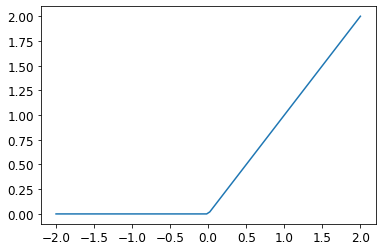

In [197]:
# A basic neural network:
# we have in simple_net 2 linear classifiers
#   each linear eq has its own weights & biases, which were randomly init'd cell)

w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

# w1 has 30 output activations, so w2 must match
# this means the 1st layer can construct 30 diff features, each repping some diff mix of pixels
# why?
# bc w/ more linear layers means more computation and model more complex fcns...
# and we can just multiply things together and add them up just once like here!
# A series of any # of linear layers in a row can be replaced w/ a single linear layer w/ a diff set of params
# But if we put a nonlinear fcn between the linear layers (such as .max),
# then each layer is decoupled from each other and can do its own thing.
# .... Universal Approx Theorem!

def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))  # ReLU
    res = res@w2 + b2
    return res


# ReLU = rectified linear unit
# it just replaces every neg number w/ a zero
# it's also avail via pyTorch as F.relu

# see it turns all neg numbers to a zero
plot_function(F.relu)

In [ ]:
### UNIVERSAL APPROXIMATION THEOREM ###
 # For any arbitrarily wiggly function, 
 #    we can approximate it as a bunch of lines joined together; 
 #    to make it closer to the wiggly function, we just have to use shorter lines. 
 # This is known as the universal approximation theorem.

# the 3 lines of code in simple_net() are the LAYERs
# 1st & 3rd lines are teh LINEAR LAYERS
# 2nd line is the NONLINEARITY, or ACTIVATION FCN

In [198]:
# Guess what?! PyTorch built-ins got yo back!

simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

# nn.Sequential() createas a module that calls each of th listed layers/fcns in turn
# nn.ReLU is a pyTorch module that does the same thing as F.relu
    # but nn.Sequential is a module, and thus req the module version of nn.ReLU()
# bc nn.Sequential is a module, we can get its parameters, 
# which returns a list of all the params of all the modules it contains

In [205]:
allParams = list(simple_net.parameters())
for param in allParams:
    print(len(param))
print(allParams[2])
print(allParams[3])
# yeah IDK what this is

30
30
1
1
Parameter containing:
tensor([[-0.1091, -0.1820,  0.1113,  0.1249, -0.0549,  0.1087,  0.0798, -0.0542,  0.0096,  0.1690, -0.1086,  0.0754,  0.1136, -0.0290, -0.1241,  0.0509, -0.1266, -0.1582,  0.0954,  0.1238, -0.1689,
          0.1072, -0.0688, -0.0100, -0.0453,  0.0080, -0.1073,  0.1608,  0.0826, -0.1494]], requires_grad=True)
Parameter containing:
tensor([-0.1238], requires_grad=True)


In [ ]:
# Hey it's Learner again!  
# This time instead of the nn.Linear() linear_model 
   # linear_model = nn.Linear(int, int)
# we're using nn.Sequential() simple_net model!
   # simple_net = nn.Sequential(nn.Linear(int, int), nn.ReLU(), nn.Linear(int, int))

learn = Learner(dls, 
                simple_net, 
                opt_func=SGD,
                loss_func=mnist_loss, 
                metrics=batch_accuracy)

In [199]:
# Let's go!
learn.fit(40, lr=0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.026140,0.030233,0.974485,00:00
1,0.023481,0.028334,0.976448,00:00
2,0.022174,0.027766,0.978901,00:00
3,0.021561,0.027562,0.977920,00:00
4,0.021275,0.027454,0.977920,00:00
5,0.021128,0.027367,0.977429,00:00
6,0.021032,0.027281,0.976938,00:00
7,0.020950,0.027192,0.976938,00:00
8,0.020870,0.027101,0.976938,00:00
9,0.020789,0.027009,0.977920,00:00


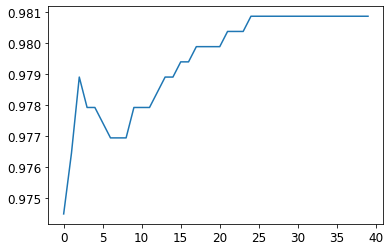

In [222]:
# learn.recorder saved the results in its .values
# print(L(learn.recorder.values))
# ^ prints out for an array of 40 arrays/epochs
# each epoch array has [train_loss, valid_loss, batch_accuracy]
# so the plot below prints out the batch_accuracy over the 40 epochs for humans

plt.plot(L(learn.recorder.values).itemgot(2));

In [223]:
# this is the batch_accuracy for the latest epoch
learn.recorder.values[-1][2]

0.9808635711669922

### Going Deeper

In [ ]:
# We can have nn.Sequential() pack as many linear layers as we want, 
# as long as we add a nonlinearity/activationFcn in between.

# But the deeper the model gets the harder it is to optimize the parameters in practice.
# There'll be some techniques intro'd later though.

# We already know that a single nonlinearity with two linear layers is enough to approximate any function. 
# So why would we use deeper models? The reason is performance. 
# With a deeper model (that is, one with more layers) we do not need to use as many parameters; 
# it turns out that we can use smaller matrices with more layers, 
# and get better results than we would get with larger matrices and few layers.
# Also means we can train model quicker, w/ less memory, yay.



In [38]:
# Check this out, an 18-layer model is actually pretty fast
# look at that ~100% accuracy!  
# Compare that to how many epochs it took our simple_net model above!

dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, 
                    resnet18, 
                    pretrained=False,
                    loss_func=F.cross_entropy, 
                    metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.088684,0.013347,0.995093,01:15


In [44]:
# I guess, as seen in 01_intro.ipynb, if we want to predict a specific input...

# not sure what I need to pjt into learn.predict() but these 3 below were wrong type...
# im3_path = threes[1]
# im3 = Image.open(im3_path)
# three_tensors[0]
learn.predict("SOMETHING")

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 118, 219, 166, 118, 118,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 103, 242, 254, 254, 254, 254, 254,  66,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  18, 232, 254, 254, 254, 254, 254, 238,  

## Jargon Recap

In [225]:
# A neural network contains a lot of numbers, but they are only of two types: numbers that are calculated, and the parameters that these numbers are calculated from. This gives us the two most important pieces of jargon to learn:

# Activations:: Numbers that are calculated (both by linear and nonlinear layers)
# Parameters:: Numbers that are randomly initialized, and optimized (that is, the numbers that define the model)

# remember Activations & Parameters are ACTUAL NUMBERS!!!
# they're contained in TENSORS
# which are simply regularly shaped arrays (such as a matrix)

# matrices have rows & cols, aka axes or dimensions.
# number of dimensions of a tensor is its RANK

# Rank 0 tensor = SCALAR
# Rank 1 tensor = VECTOR
# Rank 2 tensor = MATRIX

# A neural network contains a bunch of layers.
# each layer is either linear OR nonlinear/ActivationFcn. 
# we generaly alternate between these 2 kinds.
# Some ppl will refer to a linear layer + its subseq nonlinearity as a single layer -_-



# |ReLU | Function that returns 0 for negative numbers and doesn't change positive numbers.
# |Mini-batch | A small group of inputs and labels gathered together in two arrays. A gradient descent step is updated on this batch (rather than a whole epoch).
# |Forward pass | Applying the model to some input and computing the predictions.
# |Loss | A value that represents how well (or badly) our model is doing.
# |Gradient | The derivative of the loss with respect to some parameter of the model.
# |Backward pass | Computing the gradients of the loss with respect to all model parameters.
# |Gradient descent | Taking a step in the directions opposite to the gradients to make the model parameters a little bit better.
# |Learning rate | The size of the step we take when applying SGD to update the parameters of the model.


# Q = how to choose the nonlinearity?
# A = just regular RELU or leaky RELU is fine



## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

In [ ]:
# https://forums.fast.ai/t/fastbook-chapter-4-questionnaire-solutions-wiki/67253

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.

In [20]:
one_to_nine = torch.Tensor(list(range(1,10)))
print(one_to_nine)
a = one_to_nine.view(3,3)
print(a) 

tns = tensor([[1,2,3],[4,5,6],[7,8,9]])
tns

b = 2*a
print(b)

b[1:,1:]

tensor([1., 2., 3., 4., 5., 6., 7., 8., 9.])
tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])
tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])


tensor([[10., 12.],
        [16., 18.]])